In [122]:
from pathlib import Path

import torch
import torchinfo
import torchtext.transforms as T
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.metrics.classification import IncrementalConfusionMatrix
from torchlake.common.schemas import NlpContext
from torchlake.sequence_data.models import LSTMClassifier
from torchtext.datasets import CoNLL2000Chunking
from torchlake.common.utils.text import build_vocab
from tqdm import tqdm

# setting


In [123]:
data_path = Path("../../data/CoNLL2000")
artifacts_path = Path("../../artifacts/bilstm")

In [124]:
batch_size = 128
context = NlpContext()

# data


In [125]:
def datapipe_factory(datapipe, text_transform=None, label_transform=None):
    datapipe = datapipe.map(
        lambda item: [[word.lower() for word in item[0]], item[1]]
    ).filter(lambda item: len(item[0]) > context.min_seq_len)

    if text_transform:
        datapipe = datapipe.map(lambda item: (text_transform(item[0]), item[1]))

    if label_transform:
        datapipe = datapipe.map(lambda item: (item[0], label_transform(item[1])))

    return datapipe

In [126]:
train_data, test_data = CoNLL2000Chunking(data_path.as_posix())

In [127]:
vocab = build_vocab(map(lambda it: it[0], train_data))
label_vocab = build_vocab(map(lambda it: it[1], train_data))

In [128]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(context.max_seq_len - 2),
    T.AddToken(token=context.bos_idx, begin=True),
    T.AddToken(token=context.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(context.max_seq_len, context.padding_idx),
)

In [129]:
label_transform = T.Sequential(
    T.VocabTransform(label_vocab),
    T.Truncate(context.max_seq_len - 2),
    T.AddToken(token=context.bos_idx, begin=True),
    T.AddToken(token=context.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(context.max_seq_len, context.padding_idx),
)

In [130]:
def collate_fn(batch: list):
    text_placeholder, label_placeholder = [], []

    for row in batch:
        text, label = row[0], row[1]
        text_placeholder.append(text)
        label_placeholder.append(label)

    return torch.stack(text_placeholder), torch.stack(label_placeholder)

In [131]:
train_iter = DataLoader(
    datapipe_factory(train_data, text_transform, label_transform),
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)

test_iter = DataLoader(
    datapipe_factory(test_data, text_transform, label_transform),
    batch_size=batch_size,
    collate_fn=collate_fn,
)

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\utils\common.py:141: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


# model


In [132]:
vocab_size = len(vocab)
label_size = len(label_vocab)

In [133]:
device = torch.device(context.device)

In [134]:
model = LSTMClassifier(
    vocab_size,
    128,
    128,
    label_size,
    num_layers=1,
    bidirectional=True,
    context=context,
    is_sequence=True,
).to(device)

In [135]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
LSTMClassifier                           --
├─Embedding: 1-1                         563,968
├─LSTM: 1-2                              264,192
├─LayerNorm: 1-3                         512
├─Linear: 1-4                            12,336
Total params: 841,008
Trainable params: 841,008
Non-trainable params: 0

# train


In [136]:
epoch = 30

In [137]:
criterion = nn.CrossEntropyLoss(ignore_index=context.padding_idx, label_smoothing=0)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-4)

In [138]:
model.train()
for epoch in range(epoch):
    running_loss = 0.0

    dataset_count = 0
    for text, label in tqdm(train_iter):
        optimizer.zero_grad()

        text = text.to(device)
        label = label.to(device)

        output = model(text).permute(0, 2, 1)
        loss = criterion(output, label)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
        dataset_count += text.size(0)

    print(f"epoch {epoch+1}: {running_loss/dataset_count}")

67it [00:04, 14.40it/s]


epoch 1: 0.02213325290315187


67it [00:04, 16.08it/s]


epoch 2: 0.016161103621681234


67it [00:04, 15.61it/s]


epoch 3: 0.014216668653621603


67it [00:04, 15.64it/s]


epoch 4: 0.013006324838124105


67it [00:04, 16.02it/s]


epoch 5: 0.012128558843883116


67it [00:04, 15.46it/s]


epoch 6: 0.011453989698593296


67it [00:04, 15.77it/s]


epoch 7: 0.01091551855762503


67it [00:04, 13.74it/s]


epoch 8: 0.010467841276037159


67it [00:04, 16.04it/s]


epoch 9: 0.010077718589732896


67it [00:04, 16.23it/s]


epoch 10: 0.009748103166582868


67it [00:04, 15.81it/s]


epoch 11: 0.009463744335321348


67it [00:04, 15.28it/s]


epoch 12: 0.009216995423298274


67it [00:04, 15.77it/s]


epoch 13: 0.008982930638229669


67it [00:04, 16.08it/s]


epoch 14: 0.00878164065139952


67it [00:04, 15.46it/s]


epoch 15: 0.00859237951574041


67it [00:04, 15.75it/s]


epoch 16: 0.008424956156913913


67it [00:04, 15.92it/s]


epoch 17: 0.008263531516292203


67it [00:04, 16.02it/s]


epoch 18: 0.008114473970690326


67it [00:04, 15.52it/s]


epoch 19: 0.00798986905685334


67it [00:04, 15.77it/s]


epoch 20: 0.007866260734623048


67it [00:04, 16.02it/s]


epoch 21: 0.007739604978975075


67it [00:04, 15.70it/s]


epoch 22: 0.007634463970229697


67it [00:04, 15.64it/s]


epoch 23: 0.0075369182098378885


67it [00:04, 16.01it/s]


epoch 24: 0.007435679380128633


67it [00:04, 15.29it/s]


epoch 25: 0.007337348160347832


67it [00:04, 15.34it/s]


epoch 26: 0.00725050178120163


67it [00:04, 15.06it/s]


epoch 27: 0.007168214295559854


67it [00:04, 14.46it/s]


epoch 28: 0.007090528891769363


67it [00:04, 15.94it/s]


epoch 29: 0.0070072236929589245


67it [00:04, 14.25it/s]

epoch 30: 0.006933062135784039


# inference


In [139]:
evaluator = ClassificationEvaluator(label_size, device)

In [140]:
with torch.no_grad():
    model.eval()

    confusion_matrix = IncrementalConfusionMatrix(label_size)
    for text, label in tqdm(test_iter):
        text = text.to(device)

        output = model(text).argmax(dim=-1)

        confusion_matrix.update(
            label.view(-1).numpy(),
            output.view(-1).detach().cpu().numpy(),
        )

    print(confusion_matrix)

16it [00:01, 15.44it/s]

[[   0    0    0 ...    0    0    0]
 [   0 1949    0 ...    0    0    0]
 [   0    0 1949 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]


In [141]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(label_vocab.get_itos(), per_class_acc)

<unk>     : 0.0
<bos>     : 1.0
<eos>     : 1.0
<pad>     : 0.0
NN        : 0.7080567290283645
IN        : 0.9489151873767259
NNP       : 0.7857744107744108
DT        : 0.9673804780876494
NNS       : 0.3781456953642384
JJ        : 0.32454361054766734
,         : 1.0
.         : 0.990773962070733
CD        : 0.6443271767810026
VBD       : 0.5686862627474505
RB        : 0.45610119047619047
VB        : 0.6711462450592885
CC        : 0.984297520661157
TO        : 1.0
VBN       : 0.2829845313921747
VBZ       : 0.6144578313253012
PRP       : 0.8508014796547472
VBG       : 0.03159340659340659
VBP       : 0.5565862708719852
MD        : 0.8251599147121536
PRP$      : 0.9049881235154394
POS       : 0.9561200923787528
$         : 0.9921671018276762
``        : 0.9845201238390093
''        : 0.9841772151898734
:         : 0.9146919431279621
WDT       : 0.5891089108910891
JJR       : 0.325
WP        : 0.9181818181818182
WRB       : 0.6129032258064516
NNPS      : 0.0
JJS       : 0.0
RBR       : 0.01

d:\research\pytorch-implementations\.venv\Lib\site-packages\torchlake\common\controller\evaluator.py:63: RuntimeWarning: invalid value encountered in divide
  return np.where(total == 0, 0, hits / total)


In [142]:
per_class_acc.mean()

0.5200862049965933

d:\research\pytorch-implementations\.venv\Lib\site-packages\torchlake\common\controller\evaluator.py:82: RuntimeWarning: invalid value encountered in divide
  percentage = np.where(total == 0, 0, hits / total)


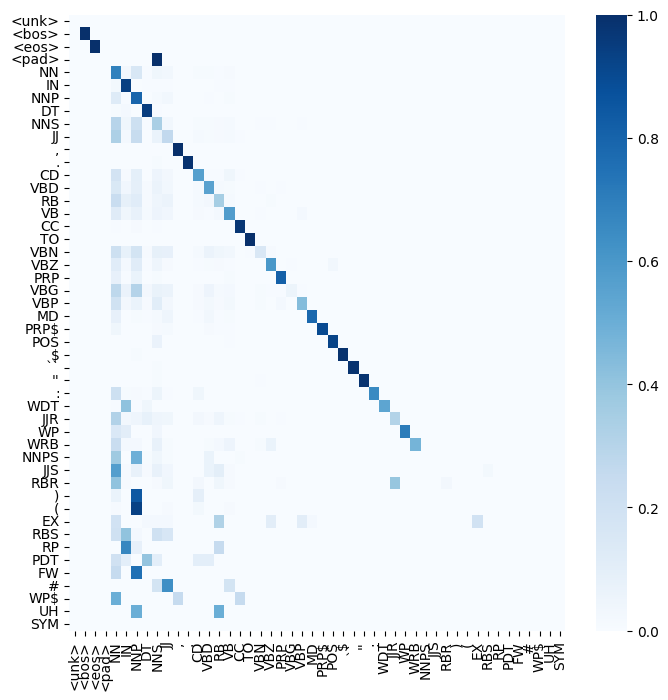

In [118]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    label_vocab.get_itos(),
    "Blues",
    annot=False,
    figsize=(8, 8),
)

In [119]:
model_path = artifacts_path / 'bilstm.pth'

In [120]:
torch.save(model.state_dict(), model_path.as_posix())

In [24]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>